## Бизнес-аналитика: проект DS (команда Фурсова)

### Описание кейса

#### Основная цель: прогноз регулярных продаж производителя еды «ПроизводительЕды»

Производителю еды «ПроизводительЕды» необходимо прогнозировать регулярные продажи sell-in. <br> Для решения задачи будут предоставлены данные: 
- Факт продаж (со скидкой и без) в детализации: Клиент, Продукт, Неделя.
- Факт проведения промо: даты, условия промо-акции

#### Загрузим необходимые библиотеки для работы с данными

In [ ]:
#ols dlt lgt

In [ ]:
#!pip install sktime[all_extras] #запустить ячейку, потом перезапустить блокнот, и уже её не запускать

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import pandas as pd
import os
import itertools

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# from sktime.forecasting.model_selection import temporal_train_test_split
# from sktime.forecasting.base import ForecastingHorizon

sns.set()

In [ ]:
# Importing everything from above

from sklearn.metrics import mean_absolute_error

# def mean_absolute_percentage_error(y_true, y_pred):
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def wape(true_array, predicted_array, multioutput=None):
  return np.sum(np.abs(true_array-predicted_array))/np.sum(np.abs(true_array))

In [ ]:
def wape_monthly(true_array, predicted_array, multioutput=None):
  predicted_array = pd.Series(predicted_array, index=true_array.index).resample('MS').apply(sum)
  true_array = true_array.resample('MS').apply(sum)
  return np.sum(np.abs(true_array-predicted_array))/np.sum(np.abs(true_array))

#### Загрузим необходимые данные для анализа

In [ ]:
train_sales = pd.read_excel("/content/train_sales_dist.xlsx", 
                             parse_dates=True, index_col="Period")
# test_sales = pd.read_excel("/content/test_sales_dist.xlsx", 
#                              parse_dates=True, index_col="Period")

## Разведочный анализ данных - факт продаж

Перед началом работы отсортируем имеющиеся данные по продажам по столбцу `Period`, чтобы было удобнее смотреть на табличные данные.

In [ ]:
customer = 29

In [ ]:
train_sales = train_sales.sort_index()
data = train_sales[train_sales['Customer'] == customer][['BPV']]

if customer in [18,34]: #для СНГ предсказания по месяцам
  data = data.resample('MS').apply(sum)


if customer in [18,34]:
  window=12 #год для помесячных (18 и 34 клиенты)
  test_size = 9  #9 месяцев
if customer in [2,14,29]:
  window=26 #6 месяцев для понедельных (2,14,29 клиенты)
  test_size = round(52/12*9) #9 месяцев

In [ ]:
# разделение на трейн/тест
#test_size = round(0.2 * len(data))
#train, test = temporal_train_test_split(data['BPV'], test_size = test_size)

if customer in [18,34]:
  freq = "M"
if customer in [2,14,29]:
  freq = "W"

# train.index = pd.PeriodIndex(train.index, freq=freq)
# test.index = pd.PeriodIndex(test.index, freq=freq)

In [ ]:
# для 2
#data.loc[data.index<=pd.Timestamp("2020-02-24"),'BPV'] = data.loc[data.index<=pd.Timestamp("2020-02-24"),'BPV']/2
# data.loc[data.index<=pd.Timestamp("2021-01-01"),'BPV'] = data.loc[data.index<=pd.Timestamp("2021-01-01"),'BPV']/1.5

In [ ]:
#для 29
data['BPV_gap'] = data['BPV'] 
data.loc[data.index<pd.Timestamp("2020-01-01"),'BPV_gap'] = data['BPV'].shift(52)

data = data[['BPV_gap']].rename({'BPV_gap':'BPV'}, axis=1)
data = data.dropna()

### Econometric

In [ ]:
# !pip uninstall matplotlib
# !pip install matplotlib==3.1.3

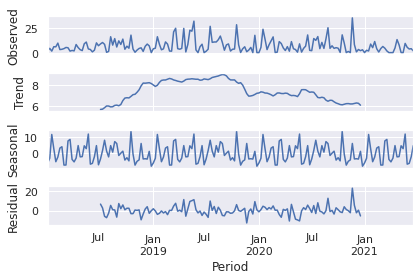

In [ ]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(data['BPV'])
resplot = res.plot()

In [ ]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickaey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

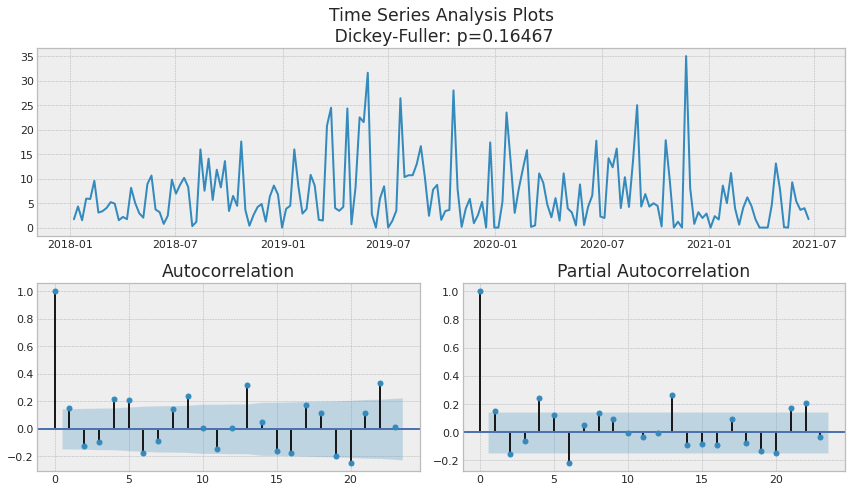

In [ ]:
tsplot(data['BPV'])

### Code plots

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

In [ ]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    

In [ ]:
def plotMovAvg_cust(df, customer, window=4, plot_intervals=True, plot_anomalies=True):
  df = df[df['Customer']==customer][['BPV']]
  plotMovingAverage(df, window, plot_intervals, plot_anomalies)
  plt.title(f"Moving average\n customer = {customer}, window size = {window}")

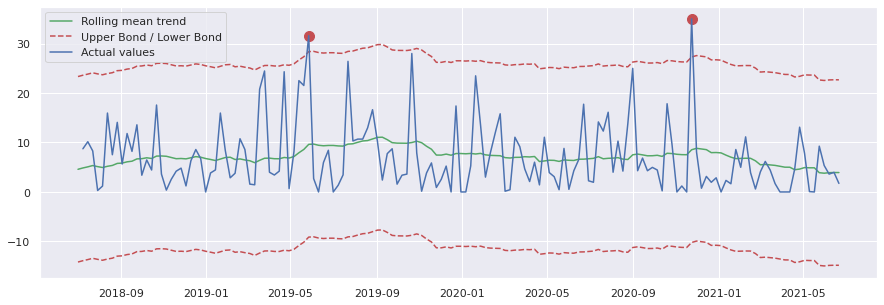

In [ ]:
plotMovingAverage(data, window, plot_intervals=True, scale=1.96, plot_anomalies=True)

# Модели

In [ ]:
model_results = {}

### Чистка аномалий

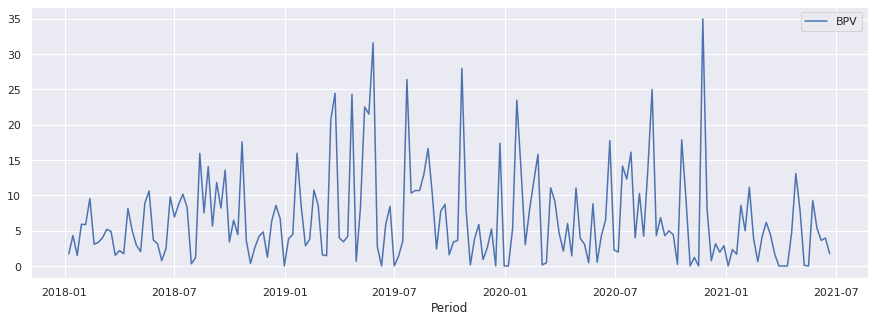

In [ ]:
plt.figure(figsize=(15, 5))
sns.lineplot(data = data)

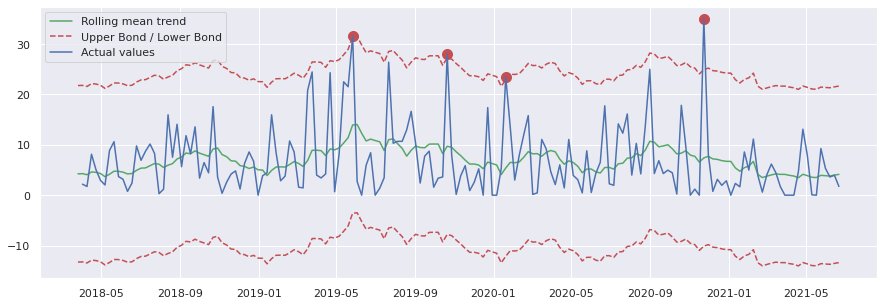

In [ ]:
plotMovingAverage(data, 12, plot_intervals=True, scale=1.96, plot_anomalies=True) # сглаживание за 6 месяцев

Чистка аномалий

In [ ]:
def correct_outliers(data, window=12, scale=1.96):
  """
  Находит все значения которые выходят за доверитленый интервал от скользящего среднего.
  От этого значений отнимает разницу, и прбавляет её к след. наблюдению
  """
  series = data
  rolling_mean = series.rolling(window).mean()

  mae = mean_absolute_error(series[window:], rolling_mean[window:])
  deviation = np.std(series[window:] - rolling_mean[window:])
  lower_bond = rolling_mean - (mae + scale * deviation)
  upper_bond = rolling_mean + (mae + scale * deviation)
  add = np.where(data - upper_bond > 0, data - upper_bond, 0)
  data = data-add+np.roll(add, 1)
  return data

In [ ]:
def correct_outliers_deleting(data, window=12, scale=1.96):
  """
  Находит все значения которые выходят за доверитленый интервал от скользящего среднего.
  От этого значений отнимает разницу, и прбавляет её к след. наблюдению
  """
  series = data
  rolling_mean = series.rolling(window).mean()

  mae = mean_absolute_error(series[window:], rolling_mean[window:])
  deviation = np.std(series[window:] - rolling_mean[window:])
  lower_bond = rolling_mean - (mae + scale * deviation)
  upper_bond = rolling_mean + (mae + scale * deviation)
  add = np.where(data - upper_bond > 0, data - upper_bond, 0)
  data = data-add
  return data

In [ ]:
data['corrected_BPV'] = correct_outliers(data['BPV'], window=6, scale=1.96)

In [ ]:
data['corrected_BPV_d'] = correct_outliers_deleting(data['BPV'], window=6, scale=1.96)

In [ ]:
# data['log_corrected_BPV'] = np.log1p(data['corrected_BPV'])

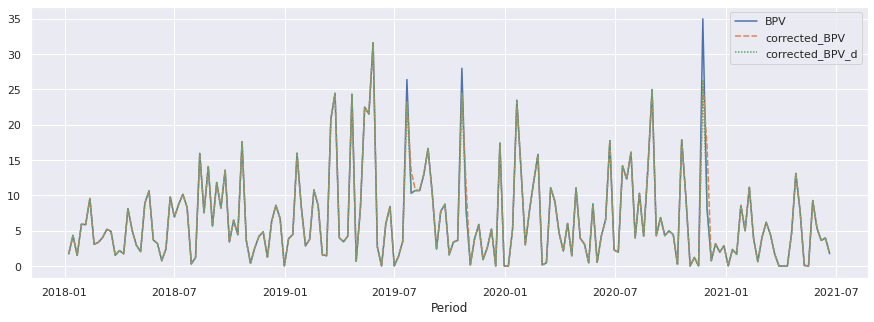

In [ ]:
plt.figure(figsize=(15, 5))
sns.lineplot(data = data)

In [ ]:
# plt.plot(data['minus_season'])

In [ ]:
# data['Week_Number'] = data.index.week

# week_means = data.groupby('Week_Number')['corrected_BPV'].mean()

# data['Week_mean'] = data['Week_Number'].apply(lambda w_n: week_means[w_n])
# data['minus_season'] = data['corrected_BPV'] - data['Week_mean']

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# data['BPV2'] = data['corrected_BPV']**2
# data['BPV3'] = data['corrected_BPV']**3

# train, test = train_test_split(data, 24)

# m = LinearRegression()
# m.fit(data.reset_index[['Period']], data['corrected_BPV'])

# preds = m.predict(data[['BPV2']])

# plt.plot(data['corrected_BPV'])
# plt.plot(data.index, preds)

In [ ]:
def cal_new_cols(data, target_column, date_column, lags, n_test, calc_features):
  """
  Расчитывает лаги и другие признаки. 
  """

  on_weekmean=calc_features.get('on_weekmean', False)
  on_monthmean=calc_features.get('on_monthmean', False)
  on_date=calc_features.get('on_date ', False)
  on_monthpart=calc_features.get('on_monthpart', False)
  on_diff=calc_features.get('on_diff', False)

  for n in lags:
    data[f'lag_{n}'] = data[target_column].shift(periods=n)

  if on_weekmean:
    data['Week_Number'] = data[date_column].dt.week
    week_means = data.groupby('Week_Number')[target_column].mean()
    data['Week_mean'] = data['Week_Number'].apply(lambda w_n: week_means[w_n])
    if not on_date:
      data = data.drop('Week_Number', axis =1)

  if on_monthmean:
    data['Month'] = data[date_column].dt.month
    month_means = data.iloc[:-n_test].groupby('Month')[target_column].mean()
    data['Month_mean'] = data['Month'].apply(lambda w_n: month_means[w_n])
    if not on_date:
      data = data.drop('Month', axis =1)
  
  if on_monthpart:
    data['Month_part']=((data[date_column].dt.day / data[date_column].dt.days_in_month) // 0.2501).values
    part_means = data.iloc[:-n_test].groupby('Month_part')[target_column].mean()
    data['Partly_mean'] = data['Month_part'].apply(lambda w_n: part_means[w_n])
    if not on_date:
      data = data.drop('Month_part', axis =1)
  
  if on_diff:
    for n in range(2):
      data[f'diff_{n+1}_{n+2}'] = (data[f'lag_{n+1}'] - data[f'lag_{n+2}'])/data[f'lag_{n+1}']
      data.replace([np.inf, -np.inf], 0, inplace=True)
    
  if on_date:
    data['Year'] = data[date_column].dt.year
    data['Month'] = data[date_column].dt.month
    try:
      if pd.infer_freq(data[target_column]) not in ['M', 'MS']:
        data['Week_Number'] = data[date_column].dt.week
    except:
      pass

  return data

In [ ]:
# def cal_new_cols(data, target_column, date_column, lags):
#   """
#   Расчитывает лаги и другие признаки. 
#   """

#   data['Year'] = data[date_column].dt.year
#   data['Month'] = data[date_column].dt.month
#   data['Week_Number'] = data[date_column].dt.week

#   week_means = data.groupby('Week_Number')[target_column].mean()
#   data['Week_mean'] = data['Week_Number'].apply(lambda w_n: week_means[w_n])


#   # month_means = data.groupby('Month')[target_column].mean()
#   # data['Month_mean'] = data['Month'].apply(lambda w_n: month_means[w_n])

#   for n in lags:
#     data[f'lag_{n}'] = data[target_column].shift(periods=n)
#   # for n in [1,2,3,6,12,24]:
#   #   data[f'sin_lag_{n}'] = np.sin(data[f'lag_{n}'])

#   for n in range(2):
#     data[f'diff_{n+1}_{n+2}'] = (data[f'lag_{n+1}'] - data[f'lag_{n+2}'])/data[f'lag_{n+1}']
#     data.replace([np.inf, -np.inf], 0, inplace=True)
#   return data

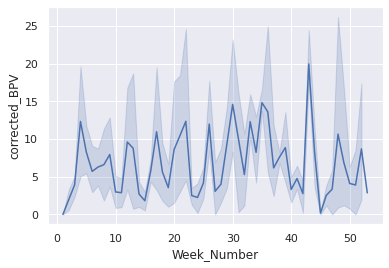

In [ ]:
lags = list(range(1,13))#+[24]
sns.lineplot(data = cal_new_cols(data.reset_index(), 'corrected_BPV', 'Period', lags), x ='Week_Number', y='corrected_BPV')

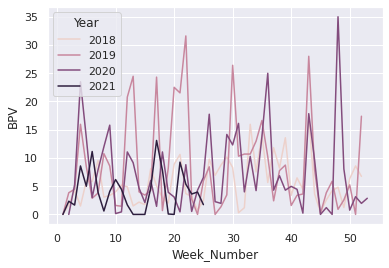

In [ ]:
lags = list(range(1,13))#+[24]
sns.lineplot(data = cal_new_cols(data.reset_index(), 'corrected_BPV_d', 'Period', lags), x ='Week_Number', y='BPV', hue='Year')

In [ ]:
def train_test_split(data, n_test):
  return data.iloc[:-n_test], data.iloc[-n_test:]

In [ ]:
# walk-forward prediction
# идея такая: раз-мы сделали лаги-признаками, значит в тестовых данных есть лики,
# поэтому чтобы из избежать будем делать по сути предсказание на 1 период вперёд,
# потом с учетом этого предсказания уже пересчитывать значения лагов
# повторяем, пока не получим предсказания для всей тестовой выборки
def walk_forward_prediction(train: pd.DataFrame, test: pd.DataFrame, target_column: str, date_column: str, features: list, model, lags: list, calc_features: dict):
	"""
	:param data: датафрейм
	:param target_column: название колонки, содержащей значения, про которым будут формироваться лаги
	:param date_column: название колонки, содержащей дату
	:param features: список дополнительных признаков
	:param model: модель
	:param n_test: кол-во наблюдений в тесте
	"""
	train_data=train.copy()
	test_data=test.copy()
	
	if (target_column != 'BPV') and ('BPV' in train_data.columns):
		train_data = train_data.drop('BPV', axis =1)
		train_data = train_data.rename({target_column:'BPV'}, axis = 1)
	
	trues = test_data['BPV'].values.copy()
	test_data['BPV'] = None
	n_test = len(test_data)

	data = pd.concat([train_data[['BPV']+features],test_data[['BPV']+features]])
	
	temp_preds = data['BPV'].values
	predictions = []
	
	data = cal_new_cols(data.reset_index(), 'BPV', date_column, lags, n_test, calc_features)
	train_data, test_data = train_test_split(data, n_test)
 
	trainX, trainy = train_data.drop('BPV',axis=1), train['BPV']
	# fit model
	model.fit(trainX.drop(date_column, axis =1).values, trainy.values)
 
	# make prediction
	for i in range(n_test):
   
		# split test row into input and output columns
		testX, testy = test_data.drop('BPV',axis=1), test['BPV']
		# fit model on history and make a prediction
		yhat = model.predict(testX.drop(date_column, axis =1).values)[i]
		predictions.append(yhat)
		
    # добавляем в датасет
		temp_preds[data.shape[0] - n_test + i] = yhat
		data['BPV'] = temp_preds


    # перерасчитываем с учетом нового столбца
		data = cal_new_cols(data,'BPV',date_column,lags,n_test, calc_features)
		train_data, test_data = train_test_split(data, n_test)

	return trues, predictions

In [ ]:
# # walk-forward prediction
# # идея такая: раз-мы сделали лаги-признаками, значит в тестовых данных есть лики,
# # поэтому чтобы из избежать будем делать по сути предсказание на 1 период вперёд,
# # потом с учетом этого предсказания уже пересчитывать значения лагов
# # повторяем, пока не получим предсказания для всей тестовой выборки
# def walk_forward_prediction(data: pd.DataFrame, target_column: str, date_column: str, features: list, model, lags: list, n_test: int):
# 	"""
# 	:param data: датафрейм
# 	:param target_column: название колонки, содержащей значения, про которым будут формироваться лаги
# 	:param date_column: название колонки, содержащей дату
# 	:param features: список дополнительных признаков
# 	:param model: модель
# 	:param n_test: кол-во наблюдений в тесте
# 	"""
# 	data_orig = data.copy()
# 	temp_preds = data_orig[target_column].values
# 	predictions = []
	
# 	data_orig = data_orig[[target_column]+features]
# 	data = cal_new_cols(data_orig.reset_index(),target_column,date_column,lags=lags)

# 	train, test = train_test_split(data, n_test)
# 	trainX, trainy = train.drop(target_column,axis=1), train[target_column]

# 	# fit model
# 	model.fit(trainX.drop(date_column, axis =1), trainy)
# 	trues = test[target_column].values.copy()
# 	test_indexes = test.index

# 	for i in range(test_indexes.shape[0]):
   
# 		# split test row into input and output columns
# 		testX, testy = test.drop(target_column,axis=1), test[target_column]
# 		# fit model on history and make a prediction
# 		yhat = model.predict(testX.drop(date_column, axis =1))[i]
# 		predictions.append(yhat)
		
#     # добавляем в датасет
# 		temp_preds[data.shape[0] - test_indexes.shape[0] + i] = yhat
# 		data_orig[target_column] = temp_preds


#     # перерасчитываем с учетом нового столбца
# 		data = cal_new_cols(data_orig.reset_index(),target_column,date_column,lags=lags)
# 		train, test = train_test_split(data, n_test)

# 	return trues, predictions

In [ ]:
def extending_window_cv(data, target_column, date_column, features, model, lags: list, calc_features, max_test_size: float):
  scores = []
  #print(f"Максимальный размер тестовой выборки: {max_test_size} наблюдений")

  for n in range(max_test_size,0,-1):
    train, test = train_test_split(data, n)
    trues, predictions = walk_forward_prediction(train, test, target_column,'Period',[], model, lags, calc_features)
    #score =  wape(true,preds)
    score =  wape_monthly(test['BPV'], predictions)
    scores.append(score)

  return np.array(scores).mean()

In [ ]:
import lightgbm as lgb

model_mae = lgb.LGBMRegressor(objective='mae')
model_mse = lgb.LGBMRegressor(objective='mse')

In [ ]:
lags = list(range(1,9)) 

calc_features = {
   'on_weekmean': False,
   'on_monthmean': False,
   'on_date ': True,
   'on_monthpart': False,
   'on_diff': True
  }
  
print(f"Обучено на исходных данных, loss - mae, WAPE: {extending_window_cv(data, 'BPV', 'Period',[], model_mae, lags, calc_features, test_size):.3f}")
print(f"Обучено на исходных данных, loss - mse, WAPE: {extending_window_cv(data, 'BPV', 'Period',[], model_mse, lags, calc_features, test_size):.3f}")
print('------------------------------------')
print(f"Обучено на скорректированных данных, loss - mae, WAPE: {extending_window_cv(data, 'corrected_BPV', 'Period', [], model_mae, lags, calc_features, test_size):.3f}")
print(f"Обучено на скорректированных данных, loss - mse, WAPE: {extending_window_cv(data, 'corrected_BPV', 'Period',[], model_mse, lags, calc_features, test_size):.3f}")
print('------------------------------------')
print(f"Обучено на скорректированных данных, loss - mae, WAPE: {extending_window_cv(data, 'corrected_BPV_d', 'Period', [], model_mae, lags, calc_features, test_size):.3f}")
print(f"Обучено на скорректированных данных, loss - mse, WAPE: {extending_window_cv(data, 'corrected_BPV_d', 'Period',[], model_mse, lags, calc_features, test_size):.3f}")

Максимальный размер тестовой выборки: 39 наблюдений
Обучено на исходных данных, loss - mae, WAPE: 0.375
Максимальный размер тестовой выборки: 39 наблюдений
Обучено на исходных данных, loss - mse, WAPE: 0.375
------------------------------------
Максимальный размер тестовой выборки: 39 наблюдений
Обучено на скорректированных данных, loss - mae, WAPE: 0.375
Максимальный размер тестовой выборки: 39 наблюдений
Обучено на скорректированных данных, loss - mse, WAPE: 0.375
------------------------------------
Максимальный размер тестовой выборки: 39 наблюдений
Обучено на скорректированных данных, loss - mae, WAPE: 0.375
Максимальный размер тестовой выборки: 39 наблюдений
Обучено на скорректированных данных, loss - mse, WAPE: 0.375


In [ ]:
plt.figure(figsize=(15,5))

#для 34 кастомера 6 наблюдений = 6 месяцев, для 2,14,29: 26 наблюдения = 6 месяцев
test_size = 26

true,preds = walk_forward_prediction(data, 'corrected_BPV', 'Period',[], model_mae,  list(range(1,13)), test_size)

plt.plot(data, label='true')
plt.plot(data.iloc[-test_size:].index, preds, label = 'pred')

plt.legend()

In [ ]:
wape(true,preds)

In [ ]:
wape(pd.Series(true, index = data.iloc[-test_size:].index).resample('MS').apply(sum),pd.Series(preds, index = data.iloc[-test_size:].index).resample('MS').apply(sum))

0.7193200133429225

In [ ]:
preds = np.where(preds < np.quantile(preds, 0.20), 1, preds)

In [ ]:
wape(pd.Series(true, index = data.iloc[-test_size:].index).resample('MS').apply(sum),pd.Series(preds, index = data.iloc[-test_size:].index).resample('MS').apply(sum))


0.6931159401997007

# GRID


In [ ]:
customers = [18,34]

grid_configs = {
    'tseries' : ['orig_series', 'corrected_series'],
    'target_columns' : ['BPV', 'corrected_BPV', 'corrected_BPV'],
    'features_configs' : itertools.product([True,False], repeat = 5),
    'objectives' : ['mae', 'mse'],
    'lags' : [range(1,6), range(1,9), range(1,13)]
}

In [ ]:
for customer in customers:
  results = []
  grid_configs = {
    'tseries' : ['orig_series', 'corrected_series'],
    'target_columns' : ['BPV', 'corrected_BPV', 'corrected_BPV_d'],
    'features_configs' : itertools.product([True,False], repeat = 5),
    'objectives' : ['mae', 'mse'],
    'lags' : [range(1,6), range(1,9), range(1,13)]
  }

  if customer in [18,34]:
    window=12 #год для помесячных (18 и 34 клиенты)
    test_size = 9  #9 месяцев
  if customer in [2,14,29]:
    window=26 #6 месяцев для понедельных (2,14,29 клиенты)
    test_size = round(52/12*9) #9 месяцев

  if customer in [18,34]:
    freq = "M"
  if customer in [2,14,29]:
    freq = "W"

  combin = itertools.product(*list(grid_configs.values()))
  for c in combin:
    tseries_mode, target_column, (on_weekmean, on_monthmean, on_date, on_monthpart, on_diff), objective, lags = c
    
    train = train_sales[train_sales['Customer'] == customer][['BPV']]
    
    if customer in [18,34]: #для СНГ предсказания по месяцам
        train = train.resample('MS').apply(sum)
    
    if tseries_mode == 'corrected_series':
        if customer == 2:
          train.loc[train.index<=pd.Timestamp("2020-02-24"),'BPV'] = train.loc[train.index<=pd.Timestamp("2020-02-24"),'BPV']/2
        elif customer == 29:
          train['BPV_gap'] = train['BPV'] 
          train.loc[train.index<pd.Timestamp("2020-01-01"),'BPV_gap'] = train['BPV'].shift(52)

          train = train[['BPV_gap']].rename({'BPV_gap':'BPV'}, axis=1)
          train = train.dropna()
        else:
          continue

    train['corrected_BPV'] = correct_outliers(train['BPV'], window=6, scale=1.96)
    train['corrected_BPV_d'] = correct_outliers_deleting(train['BPV'], window=6, scale=1.96)
    
    if customer in [34, 18]:
      on_weekmean, on_monthpart = False, False

    calc_features = {
      'on_weekmean': on_weekmean,
      'on_monthmean': on_monthmean,
      'on_date ': on_date,
      'on_monthpart': on_monthpart,
      'on_diff': on_diff
      }
    
    model = lgb.LGBMRegressor(objective=objective)
    
    score = extending_window_cv(train, target_column ,'Period',[], model, lags, calc_features, test_size)
    results.append([customer, tseries_mode, target_column, objective, f'{lags}', on_weekmean, on_monthmean, on_date, on_monthpart, on_diff, score])


  res_df = pd.DataFrame(results, columns=['customer', 'tseries_mode', 'target_column', 'objective', 'lags', 'on_weekmean', 'on_monthmean', 'on_date', 'on_monthpart', 'on_diff', 'score'])

  res_df = res_df.drop_duplicates()

  res_df.to_csv(f'val_grid_boosting__customer_{customer}.csv')